
=== Running dataset: Z-score_normalised_with_lags ===
  - CO(GT), horizon 1h
  - CO(GT), horizon 6h
  - CO(GT), horizon 12h
  - CO(GT), horizon 24h
  - NMHC(GT), horizon 1h
  - NMHC(GT), horizon 6h
  - NMHC(GT), horizon 12h
  - NMHC(GT), horizon 24h
  - C6H6(GT), horizon 1h
  - C6H6(GT), horizon 6h
  - C6H6(GT), horizon 12h
  - C6H6(GT), horizon 24h
  - NOx(GT), horizon 1h
  - NOx(GT), horizon 6h
  - NOx(GT), horizon 12h
  - NOx(GT), horizon 24h
  - NO2(GT), horizon 1h
  - NO2(GT), horizon 6h
  - NO2(GT), horizon 12h
  - NO2(GT), horizon 24h

=== Running dataset: denormalised_with_lags ===
  - CO(GT), horizon 1h
  - CO(GT), horizon 6h
  - CO(GT), horizon 12h
  - CO(GT), horizon 24h
  - NMHC(GT), horizon 1h
  - NMHC(GT), horizon 6h
  - NMHC(GT), horizon 12h
  - NMHC(GT), horizon 24h
  - C6H6(GT), horizon 1h
  - C6H6(GT), horizon 6h
  - C6H6(GT), horizon 12h
  - C6H6(GT), horizon 24h
  - NOx(GT), horizon 1h
  - NOx(GT), horizon 6h
  - NOx(GT), horizon 12h
  - NOx(GT), horizon 24h
  - NO

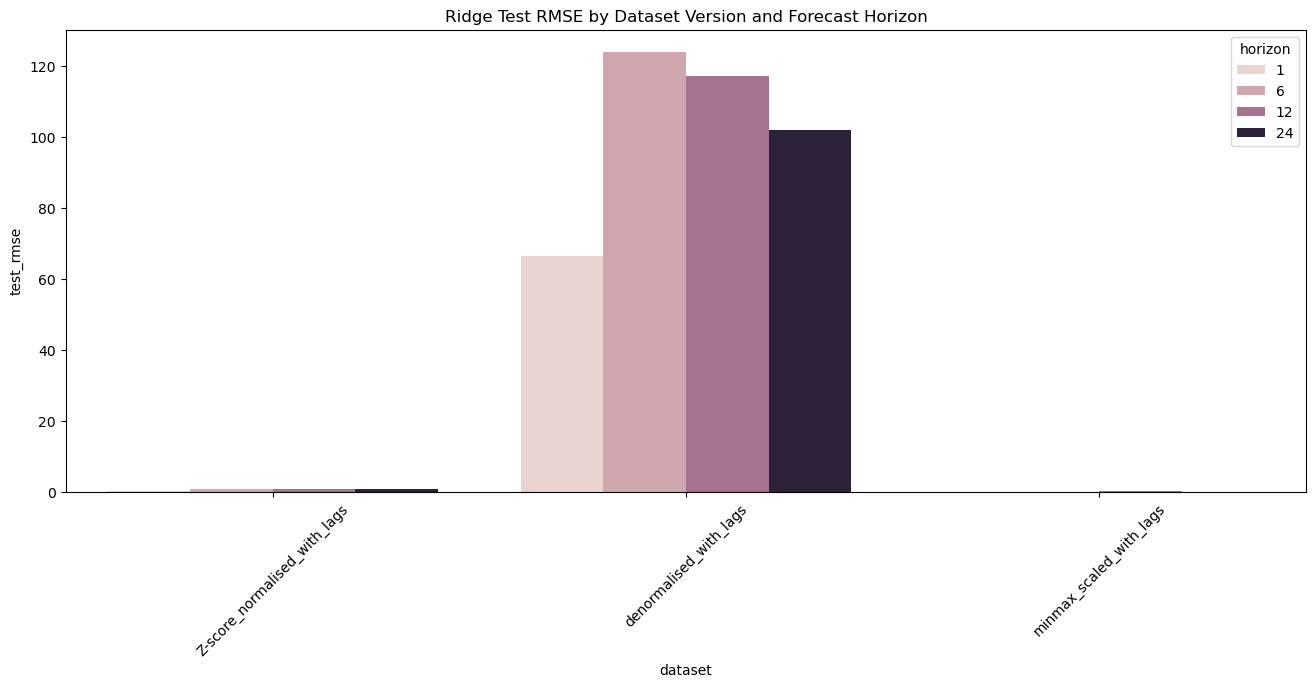

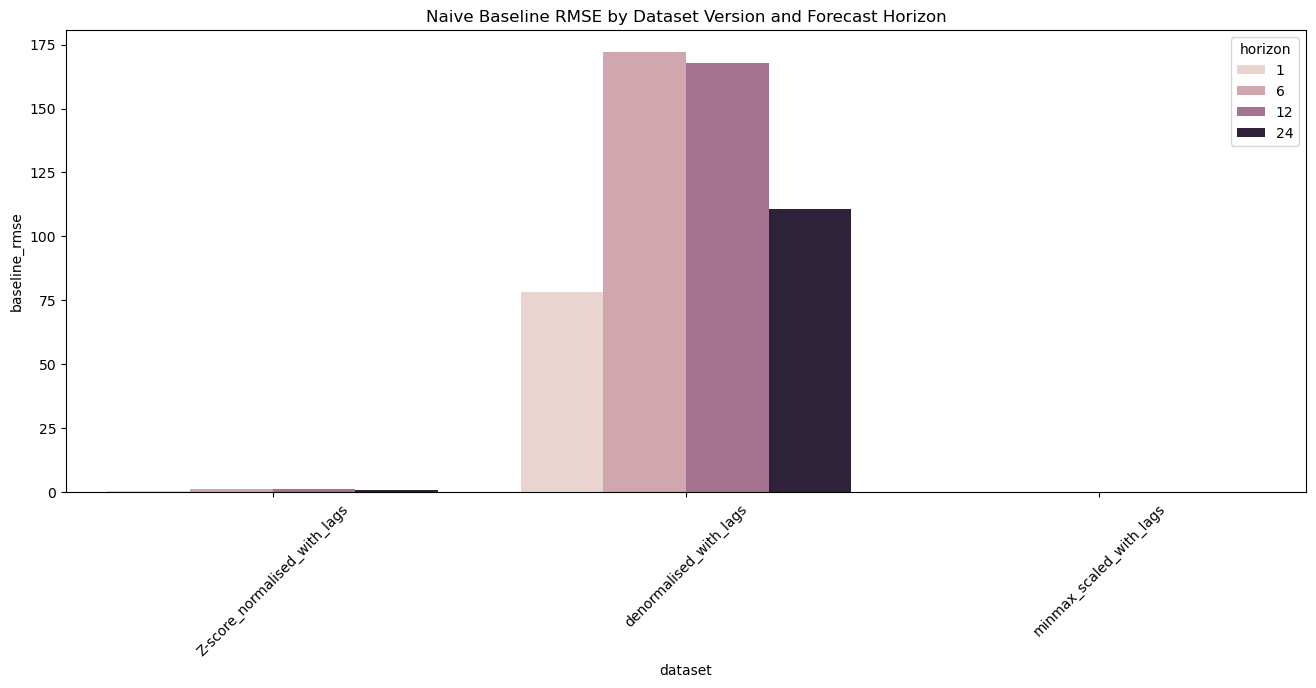


=== Best Dataset Per Pollutant × Horizon (Ridge) ===
                                   dataset pollutant  horizon  best_alpha  \
pollutant horizon                                                           
C6H6(GT)  1        minmax_scaled_with_lags  C6H6(GT)        1    3.237458   
          6        minmax_scaled_with_lags  C6H6(GT)        6  355.648031   
          12       minmax_scaled_with_lags  C6H6(GT)       12    8.286428   
          24       minmax_scaled_with_lags  C6H6(GT)       24   86.851137   
CO(GT)    1        minmax_scaled_with_lags    CO(GT)        1    5.179475   
          6        minmax_scaled_with_lags    CO(GT)        6  355.648031   
          12       minmax_scaled_with_lags    CO(GT)       12  568.986603   
          24       minmax_scaled_with_lags    CO(GT)       24  138.949549   
NMHC(GT)  1        minmax_scaled_with_lags  NMHC(GT)        1    0.790604   
          6        minmax_scaled_with_lags  NMHC(GT)        6  138.949549   
          12       min

In [12]:
import os
import re
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from polars.selectors import numeric
import itertools

# -----------------------------------------------------------
# Configuration
# -----------------------------------------------------------
DATA_DIR = "./9417_imputed_data/"
PLOT_DIR = "ridge_plots"
FI_DIR = "feature_importance_data"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(FI_DIR, exist_ok=True)

DATASETS = {
    "Z-score_normalised_with_lags": "Z-score normalised, with lags.parquet",
    "denormalised_with_lags": "denormalised, with lags.parquet",
    "minmax_scaled_with_lags": "min-max scaled, with lags.parquet",
}

TARGET_COLS = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
HORIZONS = [1, 6, 12, 24]

ALPHAS = np.logspace(-5, 5, 50)

results = []
agg_fi_rows = []

# -----------------------------------------------------------
# Helper functions
# -----------------------------------------------------------
def clean_name(c):
    return re.sub(r"[^A-Za-z0-9_]", "_", c)

def make_horizon_shift(df, target_col, horizon_h):
    return df.with_columns(
        pl.col(target_col)
        .shift(-horizon_h)
        .alias(f"{target_col}_h{horizon_h}")
    )

def build_expanding_cv(train_size, n_splits=4):
    fold_size = train_size // (n_splits + 1)
    splits = []
    
    for i in range(1, n_splits + 1):
        tr_end = i * fold_size
        val_start = tr_end
        val_end = min(tr_end + fold_size, train_size)
        if val_start >= train_size:
            break
        splits.append((np.arange(0, tr_end), np.arange(val_start, val_end)))
        
    return splits

def get_base_variable(name):
    return name.split("_lag")[0]

# -----------------------------------------------------------
# Main loop
# -----------------------------------------------------------
for version_name, filename in DATASETS.items():
    print(f"\n=== Running dataset: {version_name} ===")

    df = pl.read_ipc(os.path.join(DATA_DIR, filename))
    df = df.sort("DateTime")

    # Compute year masks for splitting
    years = pd.to_datetime(df["DateTime"].to_numpy()).year
    idx2004 = np.where(years == 2004)[0]
    idx2005 = np.where(years == 2005)[0]

    if len(idx2004) == 0 or len(idx2005) == 0:
        raise RuntimeError("Dataset must contain both 2004 and 2005 timestamps.")

    for pollutant in TARGET_COLS:
        for horizon in HORIZONS:
            print(f"  - {pollutant}, horizon {horizon}h")

            # -----------------------------------------------------------
            # Horizon shift
            # -----------------------------------------------------------
            df_shifted = make_horizon_shift(df, pollutant, horizon)
            y_col = f"{pollutant}_h{horizon}"

            df_shifted = df_shifted.drop_nulls(subset=[y_col])

            # Select numeric columns + DateTime
            df_numeric = (
                df_shifted
                .with_columns(pl.col("DateTime"))
                .select(numeric() | pl.col("DateTime"))
            )

            df_numeric = df_numeric.rename(clean_name)

            y_col_clean = clean_name(y_col)
            if y_col_clean not in df_numeric.columns:
                raise RuntimeError(f"{y_col_clean} missing after renaming")

            # Extract target
            y = df_numeric[y_col_clean].to_numpy()

            # Compute updated years after dropping rows
            dt_years = pd.to_datetime(df_numeric["DateTime"].to_numpy()).year
            idx2004_num = np.where(dt_years == 2004)[0]
            idx2005_num = np.where(dt_years == 2005)[0]

            # Predictors (drop target + DateTime)
            X = df_numeric.drop([y_col_clean, "DateTime"]).to_pandas()

            # Drop rows where any predictor is NaN
            mask = ~X.isna().any(axis=1)
            
            X = X[mask].reset_index(drop=True)
            y = y[mask]
            
            # Recompute DateTime and year masks using the filtered dataframe
            dt = pd.to_datetime(df_numeric["DateTime"].to_numpy())[mask]
            years_num = dt.year
            
            idx2004_num = np.where(years_num == 2004)[0]
            idx2005_num = np.where(years_num == 2005)[0]

            if len(idx2004_num) == 0 or len(idx2005_num) == 0:
                continue

            # -----------------------------------------------------------
            # Prepare train/CV split within 2004
            # -----------------------------------------------------------
            N2004 = len(idx2004_num)
            train_cut = int(0.85 * N2004)

            tr_start = idx2004_num[0]
            tr_end = tr_start + train_cut

            total_train_len = tr_end - tr_start

            raw_cv = build_expanding_cv(total_train_len, n_splits=4)
            cv_splits = [(tr_rel + tr_start, val_rel + tr_start) for tr_rel, val_rel in raw_cv]

            # -----------------------------------------------------------
            # Manual hyperparameter search
            # -----------------------------------------------------------
            best_rmse = float("inf")
            best_alpha = None

            for alpha in ALPHAS:
                rmses = []
                
                for tr_idx, val_idx in cv_splits:
                    model = Ridge(alpha=alpha)
                    model.fit(X.iloc[tr_idx], y[tr_idx])
                    preds = model.predict(X.iloc[val_idx])
                    rmses.append(root_mean_squared_error(y[val_idx], preds))

                avg_rmse = np.mean(rmses)

                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_alpha = alpha

            # -----------------------------------------------------------
            # Train final Ridge on all 2004 rows
            # -----------------------------------------------------------
            ridge_final = Ridge(alpha=best_alpha)
            ridge_final.fit(X.iloc[idx2004_num], y[idx2004_num])

            # -----------------------------------------------------------
            # Test evaluation on 2005
            # -----------------------------------------------------------
            y_test = y[idx2005_num]
            preds_test = ridge_final.predict(X.iloc[idx2005_num])
            test_rmse = root_mean_squared_error(y_test, preds_test)

            # -----------------------------------------------------------
            # Proper baseline
            # -----------------------------------------------------------
            shifted_idx = idx2005_num - horizon
            valid_mask = shifted_idx >= 0

            baseline_preds = y[shifted_idx[valid_mask]]
            baseline_truth = y_test[valid_mask]

            baseline_rmse = root_mean_squared_error(baseline_truth, baseline_preds)

            # -----------------------------------------------------------
            # Feature Importance: Coefficient-based
            # -----------------------------------------------------------
            coef = ridge_final.coef_
            feature_names = X.columns

            fi_df = pd.DataFrame({
                "feature": feature_names,
                "coefficient": coef,
                "abs_coefficient": np.abs(coef),
            }).sort_values("abs_coefficient", ascending=False)

            # Save CSV
            fi_path = os.path.join(
                FI_DIR,
                f"Ridge_FeatureImportance_{version_name}_{pollutant}_h{horizon}.csv"
            )
            fi_df.to_csv(fi_path, index=False)

            # -----------------------------------------------------------
            # Aggregated feature importance
            # -----------------------------------------------------------
            fi_df["base_variable"] = fi_df["feature"].apply(get_base_variable)
            agg_df = (
                fi_df.groupby("base_variable")["abs_coefficient"]
                .sum()
                .reset_index()
                .sort_values("abs_coefficient", ascending=False)
            )

            # Add metadata and append to master list
            for _, row in agg_df.iterrows():
                agg_fi_rows.append({
                    "dataset": version_name,
                    "pollutant": pollutant,
                    "horizon": horizon,
                    "base_variable": row["base_variable"],
                    "importance_sum_abs_coef": row["abs_coefficient"],
                })

            # -----------------------------------------------------------
            # Diagnostic plots
            # -----------------------------------------------------------
            base_name = f"Ridge_{version_name}_{pollutant}_h{horizon}"

            # 1. Prediction vs Actual scatter
            plt.figure(figsize=(6, 6))
            plt.scatter(y_test, preds_test, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()],
                     [y_test.min(), y_test.max()], "k--")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title(f"{version_name} | {pollutant} | h={horizon}h | Ridge")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_scatter.png")
            plt.close()

            # 2. Residuals over time
            residuals = preds_test - y_test
            plt.figure(figsize=(12, 4))
            plt.plot(residuals)
            plt.title(f"{base_name} Residuals Over Time")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_residuals.png")
            plt.close()

            # 3. Residual histogram
            plt.figure(figsize=(6, 4))
            sns.histplot(residuals, bins=40, kde=True)
            plt.title(f"{base_name} Residual Histogram")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_hist.png")
            plt.close()

            # 4. Actual vs predicted (time series)
            plt.figure(figsize=(14, 4))
            plt.plot(y_test, label="Actual")
            plt.plot(preds_test, label="Predicted")
            plt.legend()
            plt.title(f"{base_name} Time Series")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_timeseries.png")
            plt.close()

            # -----------------------------------------------------------
            # Save all scores
            # -----------------------------------------------------------
            results.append({
                "dataset": version_name,
                "pollutant": pollutant,
                "horizon": horizon,
                "best_alpha": best_alpha,
                "val_rmse": best_rmse,
                "test_rmse": test_rmse,
                "baseline_rmse": baseline_rmse,
            })

# -----------------------------------------------------------
# Save results
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("ridge_temporal_final.csv", index=False)
print("\nSaved results to ridge_temporal_final.csv")
print(results_df)

# -----------------------------------------------------------
# Save master aggregated FI CSV (NEW)
# -----------------------------------------------------------
agg_df_master = pd.DataFrame(agg_fi_rows)
agg_master_path = os.path.join(FI_DIR, "Ridge_AggregatedImportance_MASTER.csv")
agg_df_master.to_csv(agg_master_path, index=False)
print(f"Saved Ridge aggregated FI to {agg_master_path}")
print(agg_df_master.head())

# -----------------------------------------------------------
# Summary plots
# -----------------------------------------------------------
plt.figure(figsize=(16, 6))
sns.barplot(data=results_df, x="dataset", y="test_rmse", hue="horizon", errorbar=None)
plt.xticks(rotation=45)
plt.title("Ridge Test RMSE by Dataset Version and Forecast Horizon")
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=results_df, x="dataset", y="baseline_rmse", hue="horizon", errorbar=None)
plt.xticks(rotation=45)
plt.title("Naive Baseline RMSE by Dataset Version and Forecast Horizon")
plt.show()

# -----------------------------------------------------------
# Best dataset summary
# -----------------------------------------------------------
best_table = (
    results_df
    .groupby(["pollutant", "horizon"])["test_rmse"]
    .idxmin()
    .apply(lambda idx: results_df.loc[idx])
)

print("\n=== Best Dataset Per Pollutant × Horizon (Ridge) ===")
print(best_table)
